In [ ]:
%pip install chess -U

In [8]:
import chess
import chess.svg

In [2]:
from flaml.autogen.agent import AssistantAgent, UserProxyAgent, ResponsiveAgent

In [ ]:
sys_msg_tmpl = """Your name is {name} and you are a chess player. 
You are playing against {opponent_name}. 
You are playing as {color}. 
You communicate your move using universal chess interface language.
You also chit-chat with your opponent when you communicate a move to light up the mood.
You should make sure both you and the opponent are making legal moves.
For every move you communicate, you also draw the chess board after the move.
You draw the chess board using simple ASCII characters, for example:
r . b q k b . r
p p p p . Q p p
. . n . . n . .
. . . . p . . .
. . B . P . . .
. . . . . . . .
P P P P . P P P
R N B . K . N R

Have fun!
"""
player_white = AssistantAgent(
    name="player white",
    system_message=sys_msg_tmpl.format(name="player white", opponent_name="player black", color="white"),
    oai_config={"seed": 42, "temperature": 0.3},
    max_consecutive_auto_reply=5,
)
player_black = AssistantAgent(
    name="player black",
    system_message=sys_msg_tmpl.format(name="player black", opponent_name="player white", color="black"),
    oai_config={"seed": 314, "temperature": 0.8},
    max_consecutive_auto_reply=5,
)

In [ ]:
player_white.send("You go first", player_black)

In [10]:
from typing import Dict, List

from flaml.autogen.agent.responsive_agent import ResponsiveAgent
import chess

sys_msg = """You are an AI-powered chess board agent.
You translate user's natural language input into legal UCI moves.
You should only reply with a UCI move string extracted from user's input."""

user_msg_1 = """Alright, let's get this game started. I'll move pawn from e2 to e4. That's a classic opening, isn't it? Your turn."""

asst_msg_1 = "e2e4"

user_msg_2 = """I am going to move my pawn from e7 to e5."""

asst_msg_2 = "e7e5"

examples = [
    {"role": "user", "content": user_msg_1},
    {"role": "assistant", "content": asst_msg_1},
    {"role": "user", "content": user_msg_2},
    {"role": "assistant", "content": asst_msg_2},
]

class BoardAgent(ResponsiveAgent):

    def __init__(self, board: chess.Board):
        super().__init__(name="BoardAgent", system_message=sys_msg, oai_config={"temperature": 0.0}, max_consecutive_auto_reply=1, human_input_mode="NEVER")
        self._board = board
    
    def generate_reply(self, messages: List[Dict], default_reply: str | Dict = "") -> str | Dict:
        # Filter for messages that do not contain error.
        filtered_messages = []
        buf = []
        for message in messages:
            buf.append(message)
            if message.get("role") == "assistant":
                if not message.get("content").startswith("Error"):
                    filtered_messages.extend(buf)
                buf = []
        message = messages[-1]
        assert message.get("role") == "user"
        reply = super().generate_reply(messages=filtered_messages + [message], default_reply=default_reply)
        if isinstance(reply, str):
            uci_move = reply
        else:
            uci_move = str(reply["content"])
        try:
            self._board.push_uci(uci_move)
            print(f"uci_move: {uci_move}")
            m = chess.Move.from_uci(uci_move)
            display(chess.svg.board(self._board, arrows=[(m.from_square, m.to_square)], fill={m.from_square: "gray"}, size=200))
            return uci_move
        except ValueError as e:
            error = f"Error: {e}"
            print(error)
            return error

In [9]:
from typing import Dict, List

sys_msg_tmpl = """Your name is {name} and you are a chess player. 
You are playing against {opponent_name}. 
You are playing as {color}. 
You communicate your move using universal chess interface language.
You also chit-chat with your opponent when you communicate a move to light up the mood.
You should make sure both you and the opponent are making legal moves."""

class ChessPlayerAgent(ResponsiveAgent):

    def __init__(self, color: str, board_agent: BoardAgent, temperature: float, seed: int):
        if color not in ["white", "black"]:
            raise ValueError(f"color must be either white or black, but got {color}")
        if color == "white":
            opponent_color = "black"
        else:
            opponent_color = "white"
        name = f"Player {color}"
        opponent_name = f"Player {opponent_color}"
        sys_msg = sys_msg_tmpl.format(
            name=name,
            opponent_name=opponent_name,
            color=color,
        )
        super().__init__(name=name, system_message=sys_msg, oai_config={"temperature": temperature, "seed": seed}, human_input_mode="NEVER")
        self._board_agent = board_agent


    def generate_reply(self, messages: List[Dict], default_reply: str | Dict = "") -> str | Dict:
        previous_messages = list(messages)
        # add a system message about the current state of the board.
        board_state_msg = f"Current board:\n{self._board_agent._board}"
        previous_messages.append({"role": "system", "content": board_state_msg})
        while True:
            message = super().generate_reply(previous_messages, default_reply)
            if isinstance(message, dict):
                content = message.get("content")
            else:
                content = str(message)
            rewritten = {"role": "user", "content": content}
            reply = self._board_agent.generate_reply(self._board_agent._oai_conversations[self.name] + [rewritten])
            if isinstance(reply, dict):
                reply = reply.get("content")
            else:
                reply = str(reply)
            if "error" not in reply.lower():
                self._board_agent._append_oai_message(content, "user", self.name)
                self._board_agent._append_oai_message(reply, "assistant", self.name)
                return content
            else:
                previous_messages.append({"role": "system", "content": reply})


In [11]:
board = chess.Board()
board_agent = BoardAgent(board=board)
player_black = ChessPlayerAgent(color="black", board_agent=board_agent, temperature=0.5, seed=1)
player_white = ChessPlayerAgent(color="white", board_agent=board_agent, temperature=0.5, seed=2)

Player black (to Player white):

Your turn.

--------------------------------------------------------------------------------
uci_move: e2e4


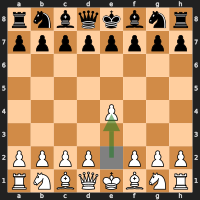

Player white (to Player black):

Alright, let's get this game started. I'll move my pawn to e4. It's always a good idea to control the center early on, isn't it? Your move, e2e4.

--------------------------------------------------------------------------------
uci_move: e7e5


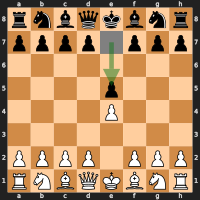

Player black (to Player white):

Indeed, controlling the center is a classic strategy. I'll respond with pawn to e5. So, e7e5. Chess is like life, isn't it? Full of decisions and consequences. Your move.

--------------------------------------------------------------------------------
uci_move: g1f3


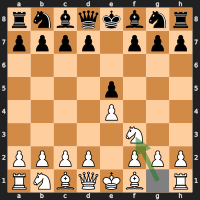

Player white (to Player black):

Couldn't agree more, the lessons we learn from chess apply to life as well. Now, let's get my knight into the game. I'll move my knight to f3. So, g1f3. Your move.

--------------------------------------------------------------------------------
uci_move: b8c6


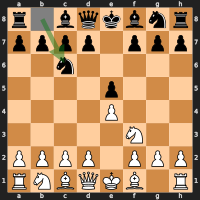

Player black (to Player white):

You've made a mistake, Player white. As you are playing white, your knight is on g1, not g8. Therefore, your move should be g1f3, not g8f3. Let's correct that.

Now, I'll move my knight to c6. So, b8c6. Chess is a game of patience and strategy, isn't it? Your move.

--------------------------------------------------------------------------------
uci_move: f1b5


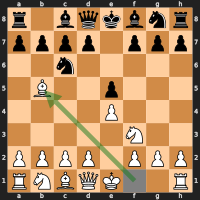

Player white (to Player black):

My apologies for the confusion earlier. You're right, chess is a game of patience and strategy. It's like a silent conversation between the players.

Now, let's get my bishop into the game. I'll move my bishop to b5. So, f1b5. Your move.

--------------------------------------------------------------------------------
uci_move: a7a6


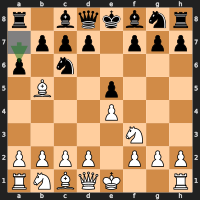

Player black (to Player white):

No worries about the confusion, it happens. And I agree, chess truly is a silent conversation.

I'll move my pawn to a6. So, a7a6. It's always good to challenge the opponent's pieces, isn't it? Your move.

--------------------------------------------------------------------------------
uci_move: b5a4


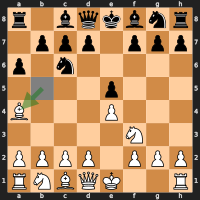

Player white (to Player black):

Indeed, it's always interesting to see how the opponent responds to challenges. I'll move my bishop to a4. So, b5a4. It's all about the balance of attack and defense, isn't it? Your move.

--------------------------------------------------------------------------------
uci_move: g8f6


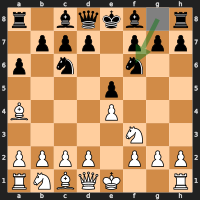

Player black (to Player white):

You're spot on, Player white. It's all about maintaining that balance. I'll move my knight to f6. So, g8f6. Chess is like a dance, isn't it? Each piece moving in sync to create a beautiful game. Your move.

--------------------------------------------------------------------------------
uci_move: e1g1


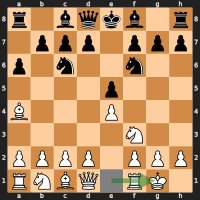

Player white (to Player black):

Your analogy is beautiful, Player black. Chess indeed is like a dance.

Now, I'll castle kingside. So, e1g1. Castling is a great way to safeguard the king and connect the rooks, isn't it? Your move.

--------------------------------------------------------------------------------
Error: illegal uci: 'e8g8' in r1bqkb1r/1ppp1ppp/p1n2n2/4p3/B3P3/5N2/PPPP1PPP/RNBQ1RK1 b kq - 3 5
uci_move: f8e7


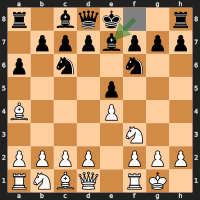

Player black (to Player white):

Apologies, Player white. I made an error. I can't castle kingside because my rook on h8 hasn't moved yet. 

Let's adjust my move. I'll move my bishop to e7. So, f8e7. It's always important to keep the king's safety in mind, isn't it? Your move.

--------------------------------------------------------------------------------
Error: illegal uci: 'e1g1' in r1bqk2r/1pppbppp/p1n2n2/4p3/B3P3/5N2/PPPP1PPP/RNBQ1RK1 w kq - 4 6
uci_move: d2d3


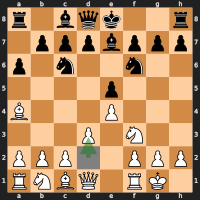

Player white (to Player black):

My apologies, Player black. You're right. I can't castle kingside because my king hasn't moved yet.

Let's adjust my move. I'll move my pawn to d3. So, d2d3. It's always important to keep the king's safety in mind, isn't it? Your move.

--------------------------------------------------------------------------------
uci_move: e8g8


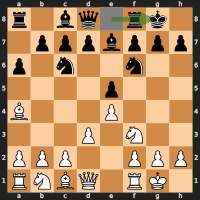

Player black (to Player white):

Indeed, safety first. I'll castle kingside now. So, e8g8. Castling is a great way to safeguard the king and connect the rooks, isn't it? Your move.

--------------------------------------------------------------------------------
uci_move: b1c3


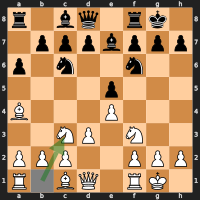

Player white (to Player black):

Indeed, castling is a key strategy in chess. Now, let's move my knight to c3, to strengthen my control of the center. So, b1c3. Your move.

--------------------------------------------------------------------------------
uci_move: e7b4


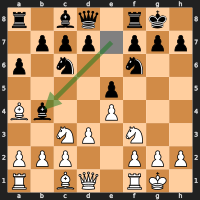

Player black (to Player white):

Indeed, controlling the center is crucial. I'll move my bishop to b4 pinning your knight. So, e7b4. Chess is a game of tactics, isn't it? Your move.

--------------------------------------------------------------------------------
uci_move: c1d2


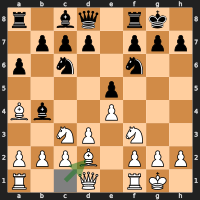

Player white (to Player black):

Indeed, chess is a game of tactics and strategy. I'll move my bishop to d2 to break the pin on my knight. So, c1d2. Your move.

--------------------------------------------------------------------------------
uci_move: b4e7


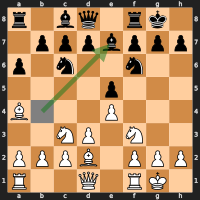

Player black (to Player white):

I see your strategy. I'll move my bishop back to e7 to keep it safe. So, b4e7. Chess is also about knowing when to retreat, isn't it? Your move.

--------------------------------------------------------------------------------
uci_move: h2h3


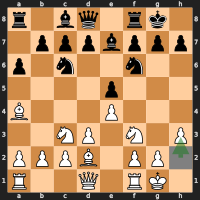

Player white (to Player black):

Indeed, knowing when to retreat is as important as knowing when to attack. Now, I'll move my pawn to h3, to give my king a little breathing room. So, h2h3. Your move.

--------------------------------------------------------------------------------
Error: illegal uci: 'a8e8' in r1bq1rk1/1pppbppp/p1n2n2/4p3/B3P3/2NP1N1P/PPPB1PP1/R2Q1RK1 b - - 0 9
Error: illegal uci: 'a8e8' in r1bq1rk1/1pppbppp/p1n2n2/4p3/B3P3/2NP1N1P/PPPB1PP1/R2Q1RK1 b - - 0 9
uci_move: f8e8


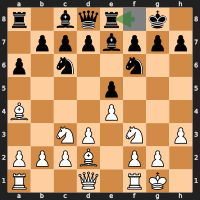

Player black (to Player white):

My apologies for the confusion earlier. You're right, the move a8e8 is not possible in the current board position.

Now, let's get my rook into the game. I'll move my rook to e8. So, f8e8. Your move.

--------------------------------------------------------------------------------
uci_move: d1e2


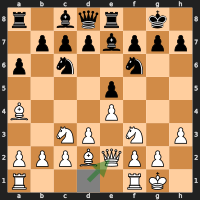

Player white (to Player black):

Indeed, bringing the rook into the game can be a strong move. Now, I'll move my queen to e2 to connect my rooks. So, d1e2. Your move.

--------------------------------------------------------------------------------
uci_move: d7d6


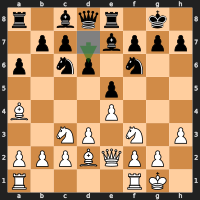

Player black (to Player white):

Indeed, connecting the rooks is a great strategy. I'll move my pawn to d6 to strengthen my control of the center. So, d7d6. Your move.

--------------------------------------------------------------------------------
uci_move: a1d1


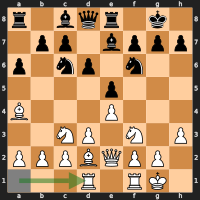

Player white (to Player black):

Your move to d6 adds more control to the center, indeed. I'll move my rook to d1 to put more pressure on your d6 pawn. So, a1d1. Your move.

--------------------------------------------------------------------------------
Error: illegal uci: 'd8e7' in r1bqr1k1/1pp1bppp/p1np1n2/4p3/B3P3/2NP1N1P/PPPBQPP1/3R1RK1 b - - 1 11
Error: illegal uci: 'd8e7' in r1bqr1k1/1pp1bppp/p1np1n2/4p3/B3P3/2NP1N1P/PPPBQPP1/3R1RK1 b - - 1 11
uci_move: d8d7


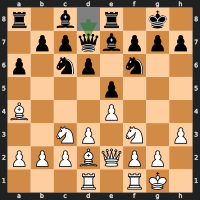

Player black (to Player white):

My apologies for the confusion earlier. You're right, the move d8e7 is not possible in the current board position.

Now, let's get my queen into the game. I'll move my queen to d7. So, d8d7. Your move.

--------------------------------------------------------------------------------
uci_move: c3d5


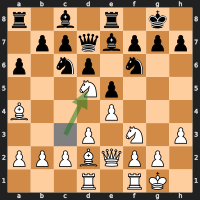

Player white (to Player black):

Indeed, getting the queen into the game can be very powerful. Now, I'll move my knight to d5 to put pressure on your pieces. So, c3d5. Your move.

--------------------------------------------------------------------------------
Error: illegal uci: 'c6d5' in r1b1r1k1/1ppqbppp/p1np1n2/3Np3/B3P3/3P1N1P/PPPBQPP1/3R1RK1 b - - 3 12
uci_move: c6d4


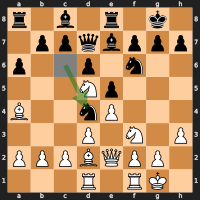

Player black (to Player white):

My apologies for the confusion earlier. You're right, the move c6d5 is not possible in the current board position.

Now, let's get my knight into the game. I'll move my knight to d4. So, c6d4. Your move.

--------------------------------------------------------------------------------
uci_move: e2e3


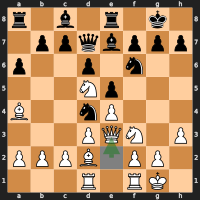

Player white (to Player black):

Indeed, bringing the knight into play can be a strong move. I'll move my queen to e3 to put pressure on your knight. So, e2e3. Your move.

--------------------------------------------------------------------------------
uci_move: d4c6


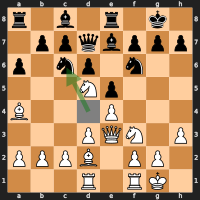

Player black (to Player white):

Indeed, moving the queen to e3 puts pressure on my knight. I'll move my knight back to c6. So, d4c6. Chess is like a dance, isn't it? Each piece moving in sync to create a beautiful game. Your move.

--------------------------------------------------------------------------------
uci_move: d5c3


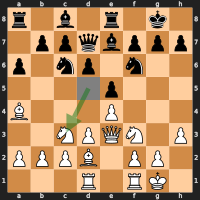

Player white (to Player black):

Indeed, the dance of the chess pieces is a sight to behold. Now, I'll move my knight to c3 to reinforce my control of the center. So, d5c3. Your move.

--------------------------------------------------------------------------------
uci_move: e8d8


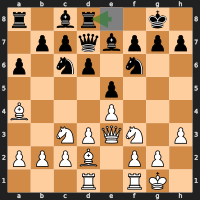

Player black (to Player white):

Indeed, moving the knight to c3 reinforces your control of the center. I'll move my rook to d8 to put more pressure on your d3 pawn. So, e8d8. Your move.

--------------------------------------------------------------------------------
uci_move: a2a3


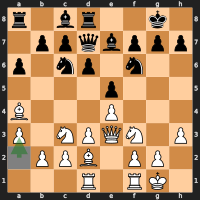

Player white (to Player black):

Indeed, moving the rook to d8 puts more pressure on my d3 pawn. I'll move my pawn to a3 to prevent any potential knight jumps to b4. So, a2a3. Your move.

--------------------------------------------------------------------------------
uci_move: d7e6


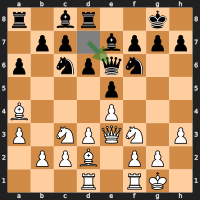

Player black (to Player white):

Indeed, moving the pawn to a3 prevents any potential knight jumps to b4. I'll move my queen to e6 to put more pressure on your e4 pawn. So, d7e6. Your move.

--------------------------------------------------------------------------------
Error: illegal uci: 'f2f3' in r1br2k1/1pp1bppp/p1npqn2/4p3/B3P3/P1NPQN1P/1PPB1PP1/3R1RK1 w - - 1 16
uci_move: f1e1


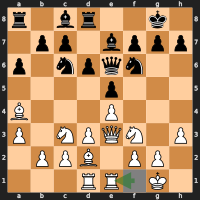

Player white (to Player black):

My apologies for the confusion earlier. You're right, the move f2f3 is not possible in the current board position.

Now, let's get my rook into the game. I'll move my rook to e1. So, f1e1. Your move.

--------------------------------------------------------------------------------
uci_move: h7h6


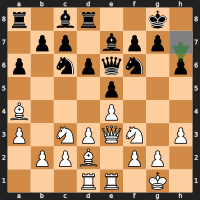

Player black (to Player white):

Indeed, moving the rook to e1 adds more control to the center. I'll move my pawn to h6 to give my king a little breathing room. So, h7h6. Your move.

--------------------------------------------------------------------------------
uci_move: d3d4


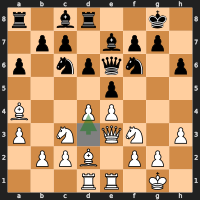

Player white (to Player black):

Indeed, moving the pawn to h6 gives your king some breathing room. Now, I'll move my pawn to d4 to challenge your control of the center. So, d3d4. Your move.

--------------------------------------------------------------------------------
uci_move: e5d4


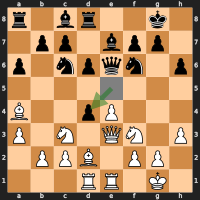

Player black (to Player white):

Indeed, moving the pawn to d4 challenges my control of the center. I'll move my pawn to exd4 to capture your pawn. So, e5d4. Your move.

--------------------------------------------------------------------------------
Error: illegal uci: 'c3d4' in r1br2k1/1pp1bpp1/p1npqn1p/8/B2pP3/P1N1QN1P/1PPB1PP1/3RR1K1 w - - 0 18
uci_move: c3d5


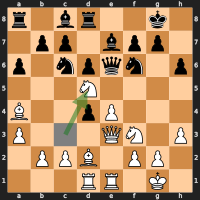

Player white (to Player black):

My apologies for the confusion earlier. You're right, the move c3d4 is not possible in the current board position.

Now, let's get my knight into the game. I'll move my knight to d5. So, c3d5. Your move.

--------------------------------------------------------------------------------
uci_move: f6d7


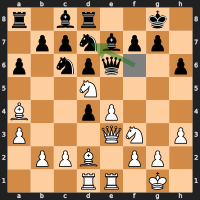

Player black (to Player white):

Indeed, moving the knight to d5 puts pressure on my pieces. I'll move my knight back to d7 to reinforce my control of the center. So, f6d7. Your move.

--------------------------------------------------------------------------------
uci_move: c2c3


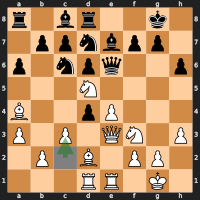

Player white (to Player black):

Indeed, moving the knight to d7 reinforces your control of the center. I'll move my pawn to c3 to challenge your pawn on d4. So, c2c3. Your move.

--------------------------------------------------------------------------------
Error: illegal uci: 'c7c5' in r1br2k1/1ppnbpp1/p1npq2p/3N4/B2pP3/P1P1QN1P/1P1B1PP1/3RR1K1 b - - 0 19
uci_move: b7b5


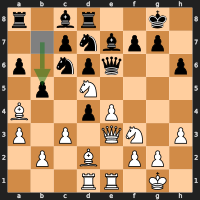

Player black (to Player white):

My apologies for the confusion earlier. You're right, the move c7c5 is not possible in the current board position.

Now, let's get my pawn into the game. I'll move my pawn to b5. So, b7b5. Your move.

--------------------------------------------------------------------------------
uci_move: a4c2


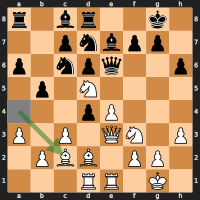

Player white (to Player black):

Indeed, moving the pawn to b5 adds more control to the queen side. I'll move my bishop back to c2 to keep it safe. So, a4c2. Your move.

--------------------------------------------------------------------------------
uci_move: d7b6


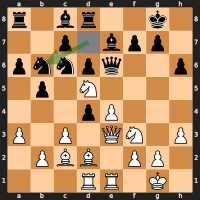

Player black (to Player white):

Indeed, moving the bishop to c2 keeps it safe. I'll move my knight to b6 to put more pressure on your knight. So, d7b6. Your move.

--------------------------------------------------------------------------------
Error: illegal uci: 'd5c3' in r1br2k1/2p1bpp1/pnnpq2p/1p1N4/3pP3/P1P1QN1P/1PBB1PP1/3RR1K1 w - - 2 21
uci_move: c2b3


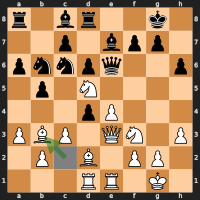

Player white (to Player black):

My apologies for the confusion earlier. You're right, the move d5c3 is not possible in the current board position.

Now, let's get my bishop into the game. I'll move my bishop to b3. So, c2b3. Your move.

--------------------------------------------------------------------------------


KeyboardInterrupt: 

In [12]:
player_black.send("Your turn.", player_white)